# Face Detection
---
이미지 속의 얼굴을 빠르고 정확하게 인식하는 방법  
- Dlib 라이브러리를 이용해서 Face Landmark를 찾아내는 방법
- YOLO, SSD 등 Face Detection을 위한 딥러닝 모델
- SOTA Face Detection 모델

#### 5개의 모델 성능 비교  
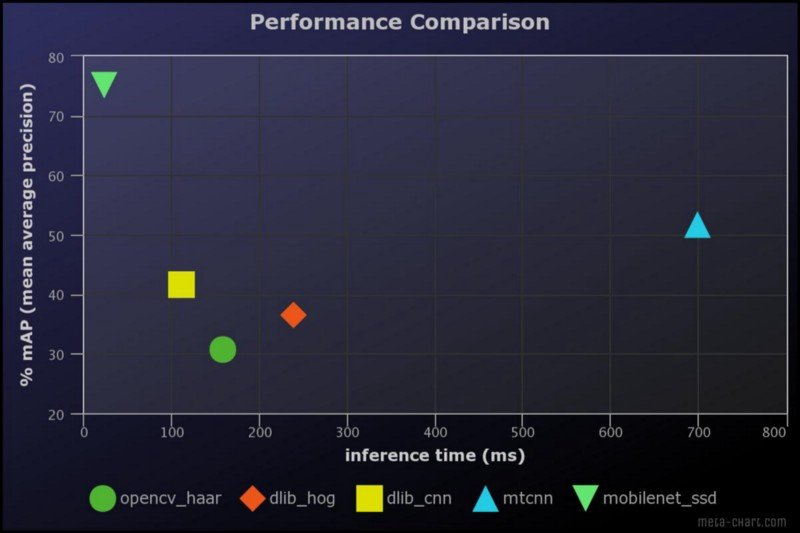  
- 가로 축 inference time : 인공지능 모델이 학습된 후 새로운 데이터를 입력 받아 예측하는 데 소요되는 시간
- 세로 축 mAP 지표 : Object Detection 분야에서 자주 사용되는 성능 지표, 높을 수록 좋은 성능을 나타냄

### Dlib 라이브러리 Face Landmark 인식 문제점
- 얼굴을 잘 못 찾는다.
- 동영상을 처리하기엔 너무 느리다.
- 얼굴각도, 방향, 크기 등의 변화에 취약하다.
- 그 외에도 많은 문제점

### 왜 작아지고 빨라지는 게 중요할까?
비대면 인증수단으로 얼굴인식이 보편적으로 사용되기 시작  
얼굴 인식을 위해 딥러닝 서버 구동이 필요한 모델을 활용할 수 있을까?  
서버로 이미지를 보낸 후 처리하는 방식은 네트워크 비용 + 서버 비용 + 인터넷 속도의 영향을 고려하지 않을 수 없다  
따라서 네트워크 상황과 무관하게 항상 동작해야 하는 핸드폰 인증 수단으로는 적합하지 않다  

그렇다면 edge device(= 핸드폰)를 바로 이용하려면?

핸드폰에 모델을 올리려면 weight가 작은 모델이 관리에 유리하지만 하지만 일반적으로 작은 모델은 성능이 떨어지기 때문에 보완 필요  

국내 IT 대기업들도 관련 연구를 활발히 진행하고 있다  
- [카카오 얼굴인식 관련 리서치](https://tech.kakaoenterprise.com/63)
- [네이버 얼굴검출 관련 오픈소스](https://github.com/clovaai/EXTD_Pytorch)  

### 어떻게 빠르게 만들 수 있을까?
Face detection에서 많은 시간이 드는 요소는 **Sliding window**를 버려야 빨라지므로, 2-stage 방식의 detection은 좋은 선택이 아니다  

또 연산의 병렬화가 가능해야 한다.   
컴퓨터의 GPU에서는 병렬화가 가능하지만 핸드폰에서도 병렬화가 가능할까?

안드로이드에서는 [MLKit](https://developers.google.com/ml-kit), 아이폰에서는 [CoreML](https://developer.apple.com/documentation/coreml)이라는 라이브러리를 통해 병렬화 가능  
하지만 제한이 많기 때문에 [TFLite](https://www.tensorflow.org/lite?hl=ko)라는 도구를 이용하여 훈련된 모델을 이용하기도 한다  
- [ios 11 machine learning for everyone](http://machinethink.net/blog/ios-11-machine-learning-for-everyone/)

위 방법으로도 해결이 안 된다면 직접 병렬프로그래밍 라이브러리를 만들어 볼 수 있다.

#### 병렬화 도구
- [SIMD-병렬-프로그래밍](https://stonzeteam.github.io/SIMD-%EB%B3%91%EB%A0%AC-%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%98%EB%B0%8D/)
- [OpenCL](https://www.khronos.org/opencl/)
- [Android: Open GL ES](https://developer.android.com/guide/topics/graphics/opengl?hl=ko)

---
## Single Stage Object Detection

#### 2-Stage Detector
- localization : 물체가 존재하는 bounding box 검출
- classification : bounding box를 분류  
정확도는 높지만 실행속도(FPS)가 느리다  

얼굴 인식과 같이 딥러닝 모델이 가벼워야 하는 task는 1-Stage 기반을 사용하는 것이 유리  

#### 1-Stage Detector
localization과 classification을 동시에 수행하여 2-Stage Detector보다는 속도가 빠르지만 정확도가 낮다  

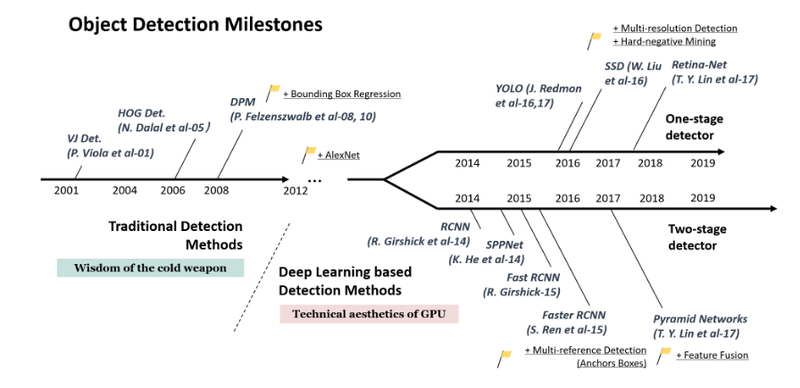  

#### [What do we learn from single shot object detectors, FPN & Focal loss?](https://jonathan-hui.medium.com/what-do-we-learn-from-single-shot-object-detectors-ssd-yolo-fpn-focal-loss-3888677c5f4d) : [번역본](https://murra.tistory.com/17)


---
## YOLO (You Only Look Once)

### YOLO v1
#### 논문: [ You Only Look Once:Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf)
|Detector|Model|mAP|FPS|
|:--|:--|:--|:--|
|2-Stage |**Faster R-CNN** |73.2    | 7 FPS (이미지 1장 당 140ms)|
|1-Stage |**YOLO v1**       |69.0    | 45 FPS (이미지 1장 당 22ms)|

#### YOLO 의 특징
**1. You Only Look Once**  
전체 이미지를 보는 횟수가 1회라는 것을 의미  
> YOLO는 클래스에 대한 정보와 주변 정보까지 한번에 학습하고 처리하여 배경 오류가 적고 일반화 성능이 좋다  

**2. Unified**  
Localization과 Classification을 동시에 수행  
> YOLO는 이미지를 신경망에 넣어주기만 하면 바로 detection이 가능  

**3. Real-Time**  
기본적인 YOLO 모델로는 45FPS(초당 프레임수), 빠른 버전은 150FPS까지 성능을 보인다(Fast R-CNN은 0.5FPS, DPM은 30FPS)
> 스트리밍 비디오에서도 실시간으로 객체를 detection 가능  

기타 Object detection을 **회귀 문제**로 관점 전환, 여러 도메인에서 object detection이 가능하다는 특징이 있다

### RCNN과 YOLO
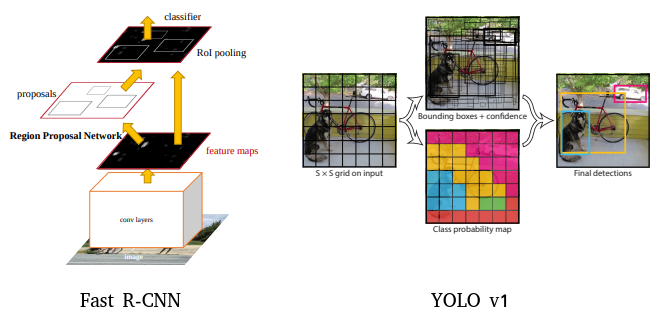  

대표적인 2-stage detector인 RCNN과 1-stage detector인 YOLO 모델의 **기본 가정 차이**가 있다

#### RCNN 계열의 가정 
> "객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다."  
    Region Proposal Network(RPN)

#### YOLO v1의 가정
> "이미지 내의 작은 영역을 나누면 그곳에 객체가 있을 수 있다."  
    grid 내에 객체가 존재한다. 따라서 YOLO v1에서 **grid는 고정**되고, **각 grid 안에 객체가 있을 확률**이 중요

### YOLO의 grid cell
YOLO는 이미지를 S x S grid로 나누고, box regression 단계와 각 클래스마다 probability map을 구하는 단계가 동시에 병렬적으로 수행된다
- 논문 : 7 x 7 grid, 각 grid cell마다 bound box(bbox) 2개, 총 클래스의 수 20

각 grid cell은 bounding box(bbox)와 C개의 class 확률을 예측한다  
각 bounding box(bbox, B)는 x, y, w, h, confidence score를 예측한다  
x, y는 bbox의 중심 좌표,w와 h는 너비와 높이  
w와 h는 입력 이미지를 bbox의 너비와 높이를 나눠서 normalize한 값(0과 1 사이의 값)  
**confidence score**는 box가 **객체를 포함할 확률(P(Object))**, 그리고 **박스가 예측한 것의 정확도(IoU)** 표현  
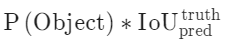  
- grid cell이 객체를 포함하지 않는다면 - P(Object) 0 ==> confidence score 0
- grid cell이 객체를 정확히 포함하고 있다면 - P(Object) 1 ==> IoU
- 따라서 confidence score가 예측된 box와 ground truth box 사이의 IoU와 같도록 하는 것이 좋다  
C개의 조건부 클래스 확률 P(Classi|Object) 은 grid cell이 사물을 포함할 때 bbox 안의 객체가 i번째 클래스에 속할 확률  
bounding box의 개수와 상관 없이 각 grid cell의 확률만 예측한다  

위의 내용을 정리하면 하나의 grid cell에 대해 아래와 같은 tensor가 나온다  
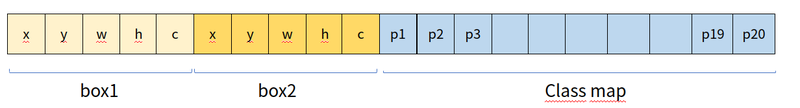  

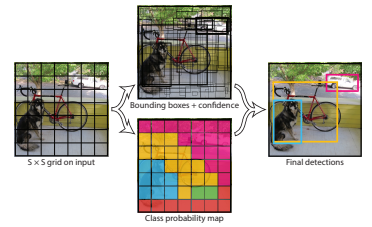  
위의 이미지에서 보면 자전거를 포함하는 grid가 많다  
이런 경우는 해당 grid의 bbox가 모두 자전거라고 예측할까?  
학습이 잘된 경우는 해당 grid들이 모두 비슷한 크기로 자전거의 bbox를 잡는데, 여기서 동일한 객체를 잡는 bbox가 많아진다는 문제 발생  

#### NMS(Non-Maximum Suppression)기법 
비-최대 억제라고도 불리는 NMS 기법은 object detector가 예측한 여러 개의 bounding box 중 정확한 bounding box만을 선택하는 기법 
1. 하나의 클래스에 대한 높은 confidence score 순서대로 bbox를 정렬하고, confidence score가 특정 threshold를 넘지 않는 것은 제거  
2. 가장 높은 Confidence Score의 bbox와 겹치는 다른 bbox를 비교하여 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거  
    - 두 bbox의 IoU가 높다는 것은 같은 객체를 detect하고 있다는 의미이기 때문
3. 1과 2의 과정을 반복해 마지막으로 남은 bbox를 반환
4. 각 클래스에 대해 위의 과정을 반복

NMS 알고리즘을 적용하면 아래와 그림과 같이 겹쳐 있는 bounding box 중 정확한 bounding box만 표시된다  
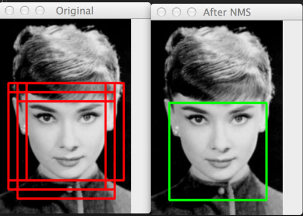  

YOLO의 목표는 grid cell에 속하는 객체를 검출

1개 grid에 귀속된 bbox 정보 (x, y, w, h)의 학습 목표 : bbox의 ground truth와 최대한 동일하도록 학습되는 것  

학습 목표가 제대로 이루어졌는지는 IoU(Intersection over Union)를 사용하여 객체 인식 모델의 성능 평가

### YOLO 네트워크 구조
24개의 Conv 레이어와 2개의 Fully connected 레이어로 구성  
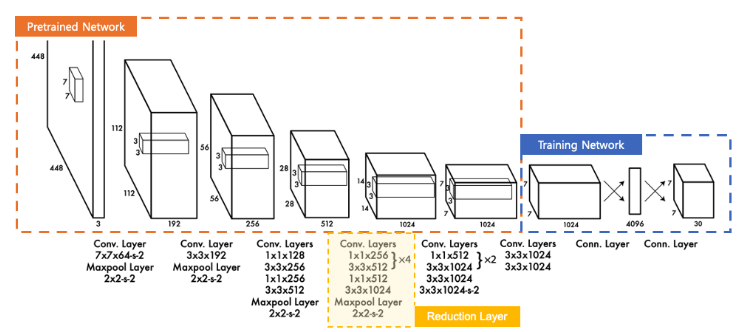  

모델 구조의 앞부분(**Pretrained**)은 ImageNet의 1000개 클래스 데이터셋을 가지고 사전학습한 **GoogLeNet 모델**  

사전학습을 위해 20개의 Conv 레이어와 average pooling 레이어와 fully-connected 레이어를 사용하였다  
그러나 GoogLeNet의 Inception 모듈 대신 **1x1 reduction 레이어를 사용**하여 연산량을 감소  

detection을 위해 사전학습된 모델에 **4개의 Conv 레이어와 2개의 FC 레이어를 추가**하였고, PASCAL VOC 데이터셋으로 fine-tuning
fine-grained 이미지를 얻기 위해 원래의 224 x 224 이미지의 2배인 **448 x 448의 이미지를 사용**

마지막 레이어는 Class 확률와 bbox 좌표를 학습하고 예측하여 S x S x (B * 5 + C) 크기의 텐서로 예측값이 출력  

### YOLO의 Inference 과정
1x1 reduction 레이어
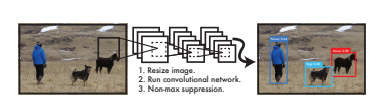  

조건부 클래스 확률 P(Classi|Object) 를 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score(class-specific confidence score)를 얻을 수 있다  
각 score는 box의 클래스의 확률과 예측된 box가 사물을 얼마나 잘 예측하는지를 보여준다
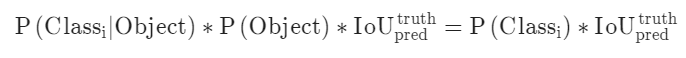  

이 과정을 모든 bbox에서 시행하면 한 이미지에서 예측한 클래스별 confidence score의 개수는 7 * 7 * 2 = 98개  

이 98개의 클래스별 confidence score에 대해 20개의 class를 기준으로 NMS하여 object에 대한 class와 bounding box location을 결정할 수 있다


---
### YOLO v1 의 loss 함수
YOLO의 loss
- bbox의 위치 예측과 관련된 localization loss
- 클래스 예측과 관련된 classification loss  

#### YOLO v1의 문제점
- 두 loss 모두 SSE(sum-squared error)를 기반으로 하는데, SSE는 이 두 loss를 동일하게 가중치를 주는 문제  
- 이미지 내 대부분의 grid cell에 객체가 없을 경우가 일반적인데, 이런 경우에는 confidence score가 0에 가깝게 되어 모델의 불균형을 초래  
    > 이런 문제를 해결하기 위해 bbox의 좌표에 대한 loss를 증가시키고, 객체가 없는 box의 confidence 예측값의 loss는 감소시켰다  
    > 이를 위해 λcoord 와 λnoobj 라는 두 개의 하이퍼파라미터를 사용
- SSE는 큰 bbox와 작은 bbox의 loss를 모두 동일한 가중치로 계산하는 문제: 작은 bbox가 큰 bbox보다 조그마한 위치 변화에도 더 민감하다
    > 이를 개선하기 위해 bbox의 너비와 높이에 square root를 취해주었다

#### YOLO의 loss 함수
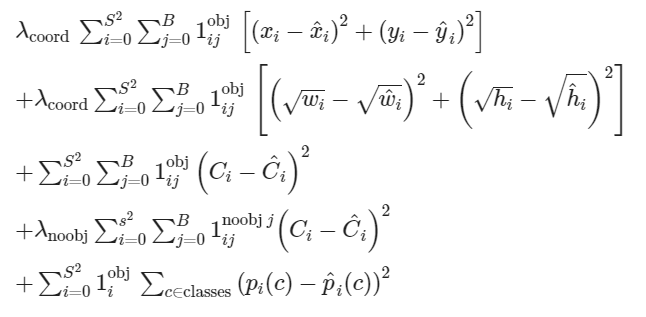  

---
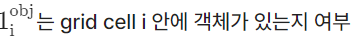
객체가 grid cell 안에 존재하면 1, 없으면 0을 출력

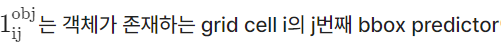
i번째 cell에 객체가 있고, j번째 predictor의 값이 다른 predictor보다 높으면 1, 그렇지 않으면 0으로 출력


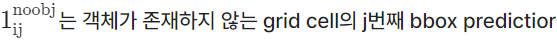

---
객체가 존재하는 grid cell i의 bbox predictor j에 대해
- 첫번째 항: x와 y의 loss 계산
- 두번째 항: 너비와 높이의 loss 계산(제곱근을 취한 SSE)
- 세번째 항: confidence score의 loss 계산

객체가 존재하지 않는 grid cell i의 bbox predictor j에 대해
- 네번째 항: confidence score의 loss 계산(객체가 없을 때의 패널티)

객체가 존재하는 grid cell i에 대해
- 다섯번째 항: 조건부 클래스 확률의 loss 계산

#### YOLO의 성능
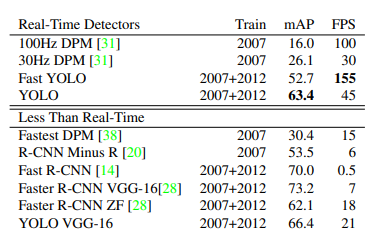  
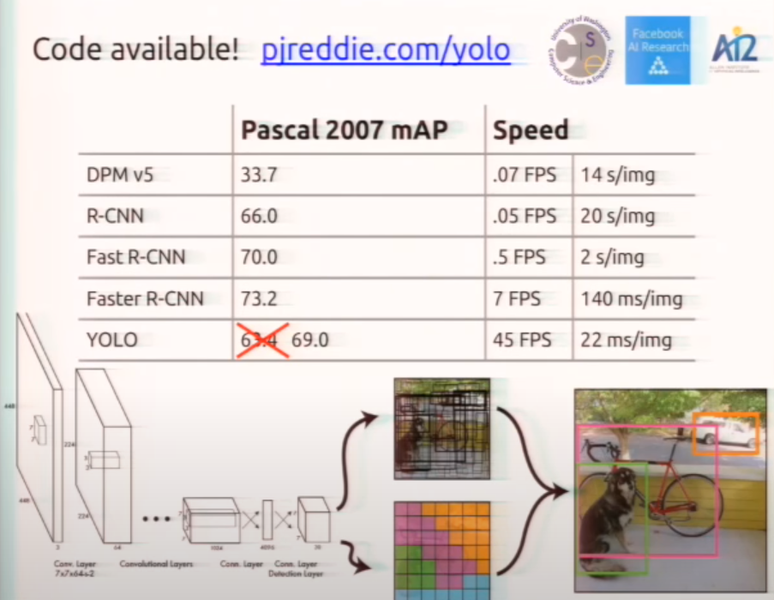  
arXiv 논문 발표에서는 mAP가 63.4였지만 CVPR 2016 발표때는 69.0으로 모델의 성능을 향상되어 발표되었다  
YOLO v1은 Faster R-CNN과 성능에 큰 차이가 나지 않으면서 속도는 6배 이상인 혁신적인 연구  

### YOLO v1의 단점
1. 각각 grid cell이 2개의 box와 하나의 클래스만 예측 가능하므로 가까이에 있는 여러 개의 객체를 예측하기 어려움  
    - 특히 새떼와 같이 그룹으로 나타나는 작은 object에 대해 예측을 제대로 하지 못했다
2. bbox의 형태가 training data를 통해 학습되었기 때문에 bbox 분산이 너무 넓어 새로운 형태의 bbox 예측이 잘 안됨  
3. 모델 구조상 backbone만 거친 feature map을 대상으로 bbox 정보를 예측하기 때문에 localization이 다소 부정확  
4. loss 함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기 때문에 큰 box의 작은 loss보다 작은 box의 작은 loss가 IoU에 더 큰 영향  

그래서 2017년 YOLO v2이 나오게 된다.

---
## YOLO v2
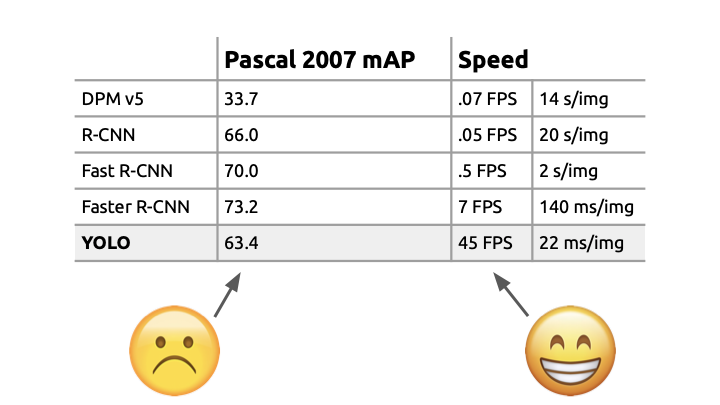  

CVPR 2016에서의 데모 중에 Redmon이 잠깐 사라진 적이 있는데, YOLO가 뒷문을 화장실로 인식해버리는 사고였다.  
Redmon은 CVPR 2017에서 이때 장면을 캡쳐해서 가지고 나왔다. 즉 YOLO의 정확도가 낮다는 것을 보여주는 한 예  

### YOLO v2의 목적
- Make it better
- Do it faster
- Makes us stronger

#### Make it better
Better는 정확도를 올리기 위한 방법  
YOLO v2에서는 이전 모델에서 낮은 성능으로 보였던 localization과 recall을 높이면서도  
여전히 모델을 단순하게 만들고 속도도 빠르게 하려고 하였다  

이를 위해 Batch Normalization, High Resolution Classifier, Convolutional with Anchor boxes, Dimension Clusters, Direct location prediction, Fine-Grained Features, Multi-Scale Training 등의 방법을 사용  

각 방법을 사용했을 때의 결과  
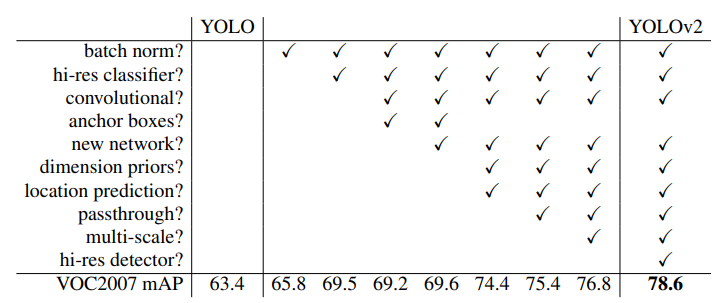  

1. Batch Normalization  
모든 conv 레이어에 batch normalizaion을 사용, dropout은 제거 
    > mAP에서 2% 이상의 성능 개선  

2. High Resolution Classifier  
YOLO v1에서 ImageNet의 224 x 224 이미지를 학습하고, detection에서 448 x 448 이미지를 사용했던 것과 달리  
YOLO v2에서는 **처음부터 448 x 448의 해상도로 학습** 
    > mAP에서 4% 정도의 성능 개선

3. Convolutional With Anchor Boxes  
bounding box를 예측하기 위해 YOLO v1의 Fully connected 레이어를 제거한 후 **Fully Convolutional Network**를 사용  
그리고 **anchor box**들을 사용하여 bounding box를 예측  
대부분의 객체가 이미지의 중앙에 있는데, 중앙에 위치한 객체의 경우는 중앙점이 하나일 경우에 더 잘 예측할 것이라는 예상 때문에,  
1개의 중앙점을 갖는 13 x 13(홀수 x 홀수)의 출력 feature map을 만들도록 **입력 이미지의 크기**를 448 x 448에서 **416 x 416**로 축소  
따라서 YOLO v2는 **13 * 13 * 5개의 bounding box**를 예측 
    > mAP는 69.5에서 69.2로 떨어지지만 recall은 81%에서 88%로 증가  

4. Dimension Cluster  
Fast R-CNN에서는 anchor box의 크기와 비율을 사전에 정해주고, 학습을 통해 세부 조정을 했지만,  
YOLO v2는 **k-means clustering을 적용**해 최적의 anchor box를 결정  
ground truth box와 유사한(IoU가 높은) anchor box를 찾기 위해서,  
유클리드 거리를 사용하는 일반적인 k-means clustering과 달리 **IoU 개념을 distance metric으로 사용**  
    > 더 좋은 anchor box를 얻을 수 있었다

클러스터링 개수를 늘리면 정확도가 높아지지만 속도가 느려지므로 YOLO v2는 최종적으로 **5개의 anchor box를 사용**  
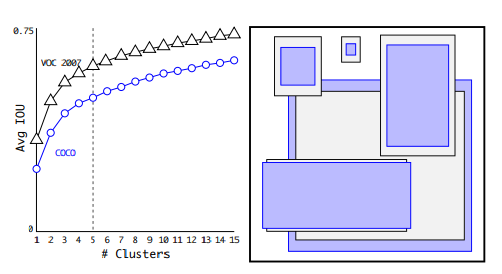  

5. Direct location prediction  
YOLO v2는 결정한 anchor box에 따라서 하나의 셀에서 **5차원의 벡터로 이루어진 bounding box**를 아래와 같은 방식으로 조정하여 예측  
학습 초반에 random initialization으로 인한 학습의 불안정을 예방하기 위해 **bounding box가 grid cell을 벗어나지 않도록 제약**  
주의할 점은 YOLO v1이 grid cell의 중앙점을 예측하였다면 **YOLO v2은 좌상단으로부터 얼마나 이동하였는지 예측**  
    > Dimension Cluster와 Direct location prediction를 사용해 약 5%의 성능 향상  
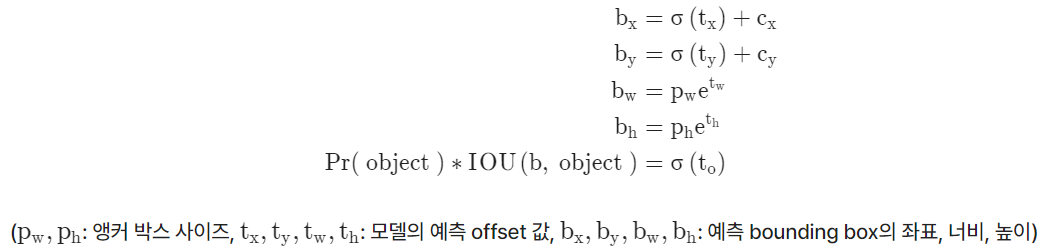  
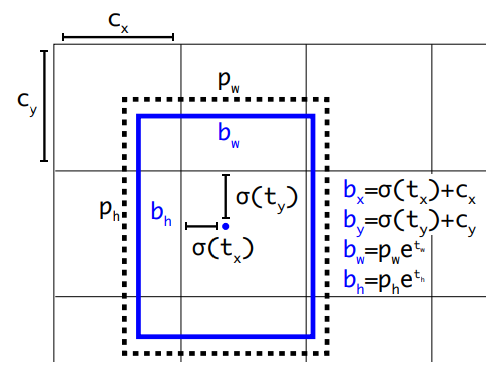  

6. Fine-Grained Features  
13×13의 feature map은 작은 물체 검출을 잘 하지 못한다는 단점이 있었기 때문에 YOLO v2는 **passingthrough 레이어 사용**  
passingthrough 레이어는 이전 레이어의 **26×26 feature map과 13×13의 feature map을 concatenate**  
이렇게 하는 이유는 26 x 26의 feature map에 Fine-Grained Features(고해상도 피처)가 담겨 있기 때문  
그러나 두 feature map의 크기가 다르기 때문에 26×26×512 feature map을 13×13×2048 feature map으로 변환한 후 concatenate하였습니다.
    > 약 1%의 성능 향상  

7. Multi-Scale Training  
모델이 다양한 입력 사이즈에도 예측을 잘 할 수 있도록 매 10개의 batch마다 **입력 이미지의 크기를 바꿔가면서** 모델 학습  
모델이 32 간격으로 downsample 되므로 입력 이미지는 32의 배수: 그래서 입력 이미지의 크기는 {320, 352, ... 608} 중 하나가 사용  

#### Do it faster
faster는 detection 속도를 향상시키기 위한 방법  

**Darknet-19**  
YOLO v2에서 가중치 파라미터 수를 크게 줄이기 위해 Fully Connected 레이어를 제거하고  
**global average pooling**을 하여 만든 최종 모델  
**19개의 convolutional 레이어**와 **5개의 maxpooling 레이어**로 구성  
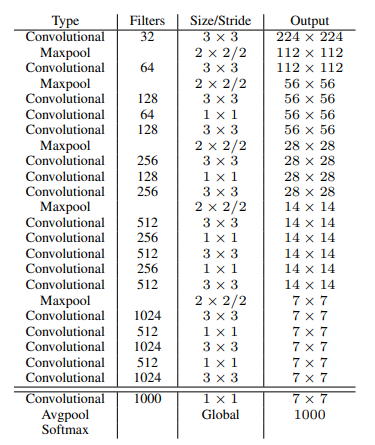  

DarkNet-19를 통과한 YOLO v2의 **최종 출력은 13x13x125**  
> feature map 13x13  
> 5개의 bounding box를 예측  
> 하나의 bounding box가 x, y, w, h, confidence를 예측(5) + 클래스의 개수(20)  
> 13 x 13 x (5 * (5 + 20))

#### Makes us stronger
더 많은 범위의 class를 예측하기 위한 방법  

YOLO v1는 PASCAL VOC 데이터셋에서 제공되는 20개의 클래스를 기준으로 학습해서 20개의 클래스만 detection  
YOLO v2에서는 **9천개의 클래스에서 detection** (모델 YOLO9000, 논문명 YOLO9000: Better, Faster, Stronger)

**YOLO 9000**은 YOLO v2와 모델 구조가 같고 detection하는 라벨을 늘렸다  
9천개의 클래스에 대해 분류를 하기 위해 **계층적으로 분류 작업(Hierachical Classification)을 수행**하여  
기존의 WordNet 기반의 데이터를 트리 구조인 **WordTree를 생성**하였습니다.
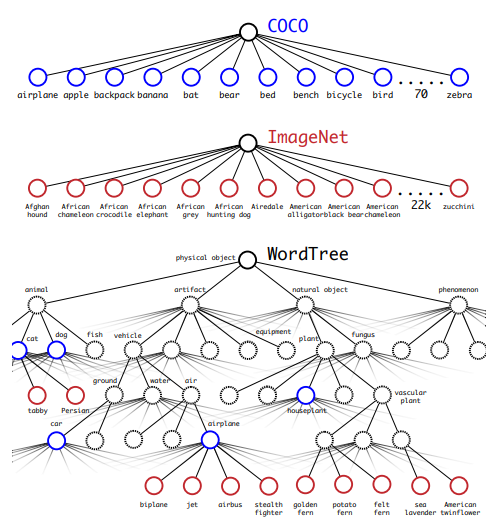  

**ImageNet + COCO 데이터셋 + ImageNet Detection**을 합쳐 9천개의 클래스 라벨을 생성  
그 후 Detection과 Classification을 합쳐서 학습  
> Detection 데이터셋과 Classification 데이터셋을 oversampling하여 비율을 4:1로 맞췄다(데이터 셋 개수가 차이가 크기 때문)  
Detection 데이터셋은 classification과 bbox에 대한 loss를 역전파하여 학습  
Classification 데이터셋은 classfication loss만 역전파하여 학습  

||YOLO v1|YOLO v2|
|:--|:--|:--|
|모델|Darknet 모델|Darknet-19 모델(파라메터 수 감소:속도 개선)|
|학습 이미지|224x224 이미지를 학습, detection에서 448x448 이미지 사용|처음부터 448x448 해상도로 학습|
|grid, anchor box|7 X 7 grid, anchor box 2개|13 X 13 grid, anchor box 5개(5차원 백터)|
|bounding box 예측|grid cell의 중앙점 예측|grid cell 좌상단으로부터 이동값 예측|
||Fully connected 레이어 사용|Fully Convolutional Network 사용, k-means clustering을 적용|
|Batch Normalization||모든 Conv 레이어에 Batch Normalization 사용, dropout 제거|
|작은 물체 검출||passingthrough 레이어 사용|
|다양한 입력 사이즈 예측||Multi-Scale Training|


### YOLO v2 의 성능비교
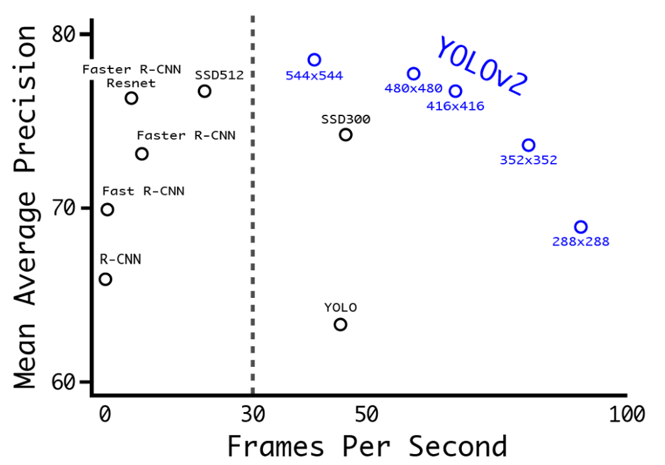  

YOLO v2의 성능은 위의 그래프에서도 볼 수 있듯이 mAP가 상승하고 FPS도 개선되었다  
그러나 여전히 mAP와 FPS간의 trade-off가 존재  

YOLO v2 발표 당시 SSD, R-FCN 등이 이미 발표된 상황이었다.  
특히 SSD와 YOLO는 같은 single stage 방법을 지향하고 있었기 때문에 경쟁 모델이 되었고,  
YOLO v2 입장에서는 SSD와의 성능 차이를 부각시키는게 중요한 과제였다  

---
## YOLO v3

### RetinaNet의 도발
YOLO v2를 언급하면서 보통 figure에는 그려주지도 않는 신선함을 보여주었고, 실제로 retinanet 성능이 YOLO v2보다 좋기도 했다
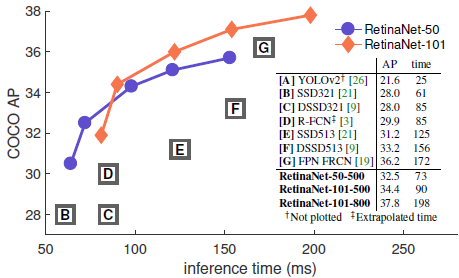  

Redmon은 새로운 YOLO(v3)를 들고 RetinaNet과 정면 비교  
RetinaNet figure를 그대로 가지고 와서 YOLO v3 성능 표기  
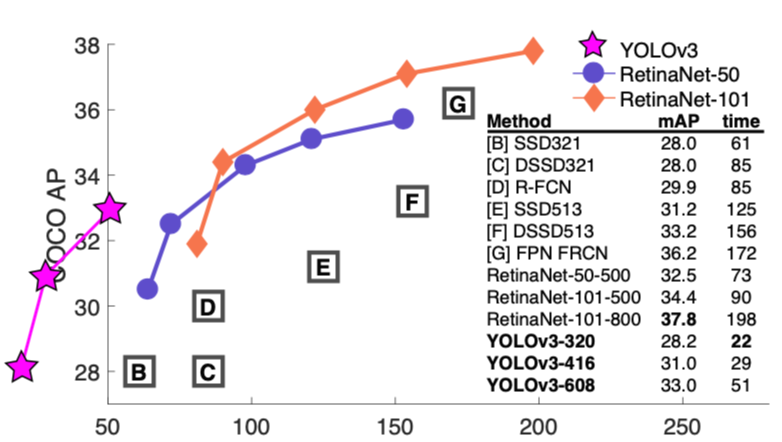  

### YOLO v3 원리
YOLO v3는 YOLO v2보다는 속도는 조금 느리지만 정확도를 개선한 모델  
특히 YOLO의 약점이었던 작은 물체 detection 성능 개선  

논문(Tech Report) : [YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767)

1. Bounding Box Prediction  
**각각의 bounding box마다 objectness score**(box에 물체가 있는지의 점수)를 **logistic regression**을 사용하여 예측
anchor box와 ground truth box의 IoU가 가장 높은 박스의 objectness score는 1로 두고 나머지는 무시  
또한 Faster R-CNN 등의 다른 모델과 달리 각각의 ground truth에 대해 1개의 bounding box만 가지게 된다는 차이가 있다
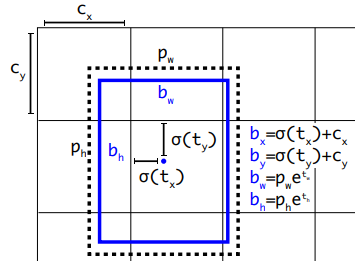  

2. Class prediction  
YOLO v3는 하나의 이미지에 다양한 label을 붙일 수 있는 **multilabel classification**를 하였다  
예를 들어 여성의 이미지에 person과 woman이라는 두 가지의 label을 붙일 수 있는 것을 의미  
이를 위해 여러 개 중 하나만 찾는 softmax classifier가 아닌  
해당 label이 맞는지 아닌지를 판단하는 **logistic classifier**를 사용하였고, **binary cross entropy**를 사용해 loss를 계산  


3. Predictions Across Scales  
YOLO v3은 3개의 scale로 각 scale당 3개의 bouding box 예측 - 총 9개의 bouding box
텐서 : N × N × [3(anchor box) ∗ (4(x,y,w,h) + 1(objectness score) + 80(클래스 수))]
또한 feature map을 2배씩 upsampling (13, 26, 52)
> 더 의미 있는 semantic information을 얻고, 이전 feature map과 concatenate하여 보다 fine-grained한 정보를 얻을 수 있었다

4. DarkNet-53  
성능을 높이기 위해 YOLO v3은 53개의 레이어를 사용  
YOLO v2의 아키텍처였던 DarkNet-19에 **residual network**를 넣어 레이어를 53개까지 쌓을 수 있었다.
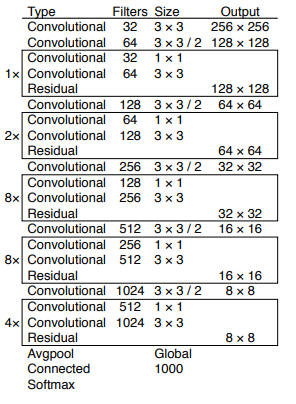  
> DarkNet-53은 DarkNet-19보다 정확도가 높았고, ResNet-101이나 ResNet152과 성능이 비슷하지만 연산면에서 효율적
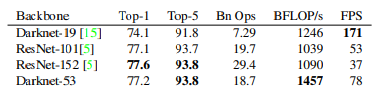  

### 전체 모델 구조
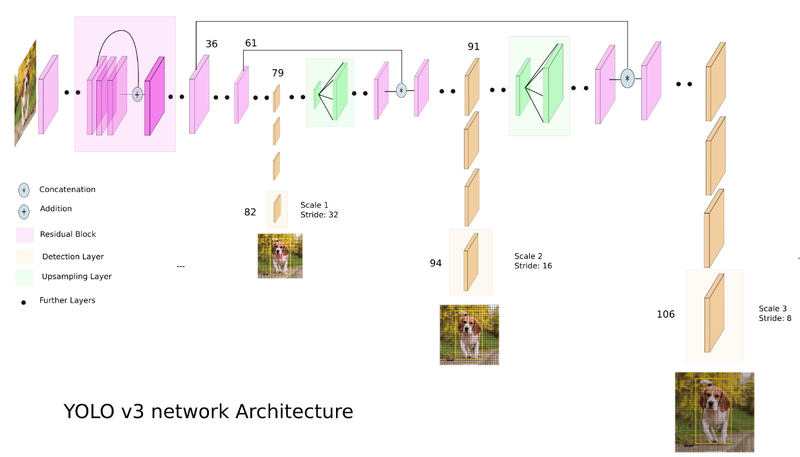  
입력 이미지를 DarkNet-53에 통과시켜서 downsampling하면서 feature map을 추출  
이 feature map을 토대로 detection을 하고, upsampling 후 다시 detection하고 다시 upsampling을 한 후에 detection  
(3개의 scale된 bounding box를 이용한 detection)
> 여러 개의 label에 대해서도 classification 가능

||YOLO v2|YOLO v3|
|:--|:--|:--|
|모델|DarkNet-19|DarkNet-53|
|Bounding Box 예측|grid당 anchor box 5개(5차원 백터) 예측|3개의 scale로 각 scale당 3개의 bouding box 예측 - 총 9개의 bouding box|
|Class 예측|singlelabel classification|multilabel classification|
||softmax classifier|logistic classifier|
||13 × 13 × [5(anchor box) ∗ (4(x,y,w,h) + 1(confidence score) + 20(클래스 수))]|N × N × [3(anchor box) ∗ (4(x,y,w,h) + 1(objectness score) + 80(클래스 수))]|


---
## YOLO v3 이후
Redmon은 Computer Vision 연구가 자신의 목적과는 다르게 군사적으로 사용되고 있는 것에 큰 회의감을 느끼고 CV 연구를 그만두겠다고 선언  
YOLO 등 DarkNet 프로젝트는 Alexey Bochkovskiy가 메인테이너로 이어 받게되고, 그 이후에도 다양한 사람들에 의해 YOLO를 이용한 다양한 모델 생성

### YOLO v4
Redmon이 빠진 후 Alexey Bochkovskiy가 2020년 4월에 YOLO v4를 발표  
> YOLO v3보다 AP와 FPS가 각각 10%, 12% 증가  
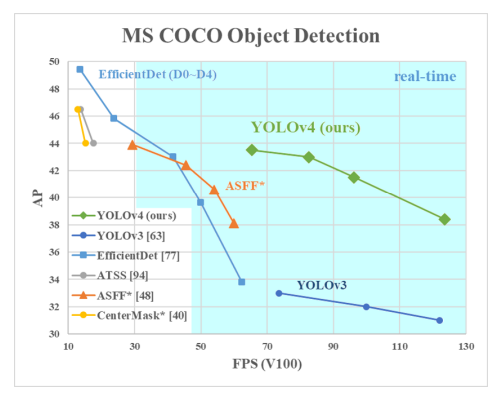  

논문 [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/pdf/2004.10934.pdf)

YOLO v3에 다양한 기법을 사용해 하나의 GPU(1080 Ti 또는 2080 Ti)로 object detection을 실시간으로 할 수 있도록 만든 모델  

- 백본으로는 CSPDarknet53을 사용
- Neck(feature map 정제 및 재구성)으로는 SPP와 PAN
- Head(object classification, localization)에서는 YOLO v3를 사용

YOLO v4 = YOLO v3+ CSPDarknet53 + SPP + PAN(Path Aggregation Network) + BoF(Bag of Freebies) + Bos(Bag of Specials)  

**Bag of Freebies**는 Inference cost의 변화 없이 성능을 향상시키는 방법으로 전처리 또는 학습 단계에서 사용  
> Data Augmentation, Regularization, Loss Function 등  

**Bag of Specials**는 inference cost가 조금 상승하면서 성능을 향상시키는 방법으로, Inference 단계나 후처리 단계에서 사용  
> Enhance Receptive field, Feature Integration, Activation function, Attention Module, Normalization, Post Processing 등

### YOLO v5
YOLO v5는 2020년 6월에 YOLO v3을 PyTorch로 구현한 Glenn Jocher에 의해 발표  
하지만 YOLO v5는 처음으로 논문과 함께 발표되지 않은 최초의 모델이자, DarkNet이 아닌 PyTorch로의 구현이므로 기존의 YOLO 모델과 많이 다르다는 이유로, YOLO v5라는 이름에 대해 논란이 있었던 모델  
YOLO v5의 코드는 Ultralytics LLC라는 회사의 깃헙에 공개되어 있다  

YOLO v4와 성능은 비슷하지만 용량이 훨씬 작고 속도도 빠르다
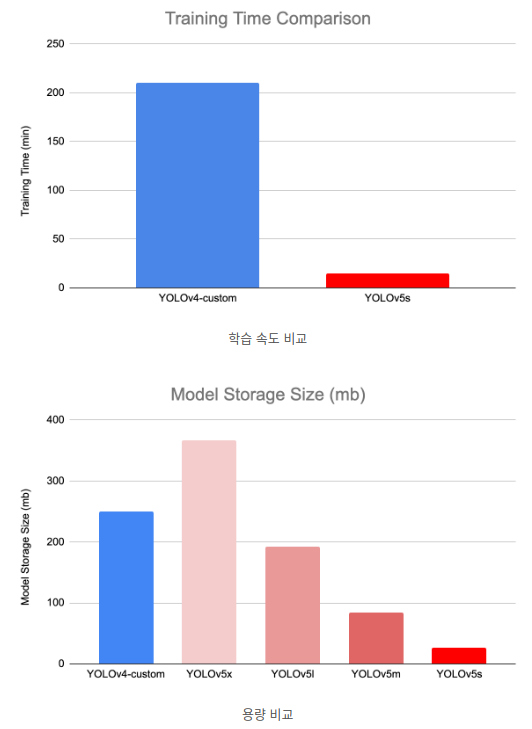  

YOLO v5는 OLOv5s, YOLOv5m, YOLOv5l, YOLOv5x라는 이름의 4가지 버전이 있다  
각각 small, medium, large, xlarge로, 백본이나 head는 동일하지만 모델 깊이와 레이어의 채널 수가 다르다  
YOLOv5s는 (0.33, 0.50), YOLOv5m은 (0.67, 0.75), YOLOv5l은 (1.0, 1.0), YOLOv5x는 (1.33, 1.25)의 비율  
성능은 s가 가장 빠르고, 정확도는 x가 가장 높다  
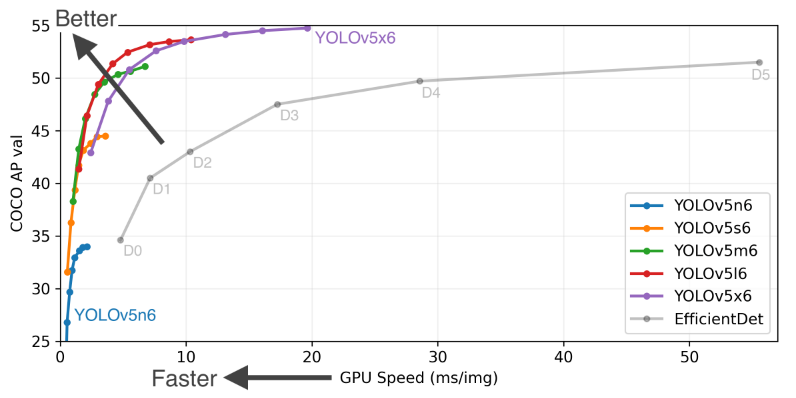  

YOLO v4의 백본과 유사하게 CSP-Darknet을 사용  
YOLO v3과 동일하게 3가지 scale에서 bounding box를 각각 3개씩 찾는다  

참고 : [YOLO V5 환경 셋팅 및 모델 아키텍쳐 분석하기](https://ropiens.tistory.com/44)

### PPYOLO
PPYOLO는 2020년 8월에 바이두에서 발표된 모델 (PP : 바이두에서 만든 오픈 소스 딥러닝 전용 프레임워크 PaddlePaddle의 약자)
PaddlePaddle을 이용해 구현한 YOLO 계열의 모델  

논문 [PP-YOLO: An Effective and Efficient Implementation of Object Detector](https://arxiv.org/pdf/2007.12099.pdf)  
YOLO v4와 비슷하게, 좋다고 알려진 다양한 기법을 사용해 YOLO v3의 성능을 올린 과정을 소개

그러나 일반적인 방법을 사용해 YOLO v3의 성능을 올리기 위해서  
YOLO v4와 달리 백본 네트워크, Data augmentation, NAS 등은 사용하지 않았다  
만약 YOLO v4에서 사용한 기법을 사용하면 PPYOLO의 성능은 더 좋아질 것이라고 한다

PPYOLO의 기본 구조는 YOLO v3와 거의 동일  
다른 것은 백본을 DarkNet-53 대신 ResNet50-vd를 사용한 것과 Inject Points 3가지가 추가로 적용된다는 것  
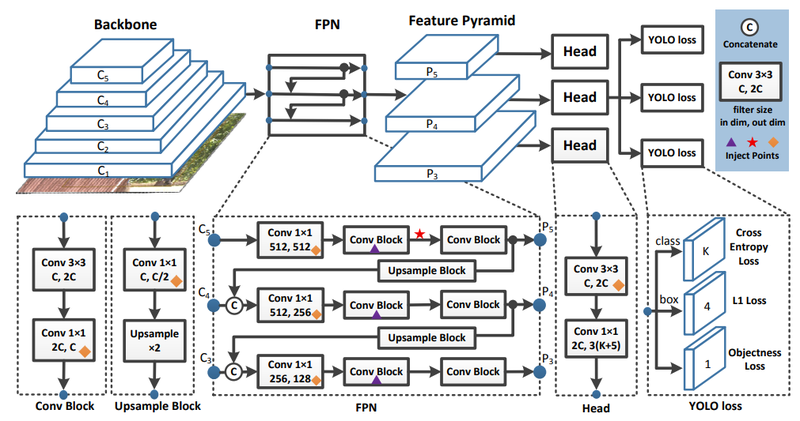  

YOLO v4와 비슷하게 Larger Batch Size, EMA, DropBlock Regularization, SPP 등 다양한 방법을 사용해 실험을 하였다
> PPYOLO의 성능은 YOLO v4보다 정확도와 속도가 높다
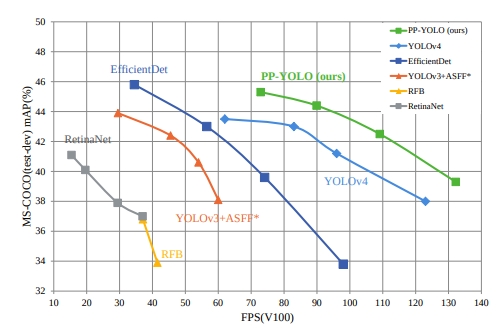  

### Scaled YOLO v4
2020년 11월, YOLO v4에 scaling 기술을 적용한 Scaled YOLO v4가 공개  
논문 [Scaled-YOLOv4: Scaling Cross Stage Partial Network](https://arxiv.org/pdf/2011.08036.pdf)

다양한 디바이스 환경에서 실시간으로 객체를 탐색하면서도 높은 정확도를 갖출 수 있도록 YOLO v4 모델에 scaling 기술을 적용  
YOLO v4 -> YOLOv4-CSP-> Scaled YOLO v4의 순서로 모델을 만들었다  

YOLO v4에 CSP를 적용한 이유  
> 기존 모델에 CSPNet을 적용하면 FLOPs(FLoating point Operations Per Second)을 현저히 줄일 수 있기 때문

또한 모델의 scaling의 상한과 하한을 정해 YOLOv4-large와 YOLOv4-tiny model을 만들었다

#### YOLO v4-large의 아키텍처
먼저 CSP를 완전히 적용한 YOLOv4-P5를 디자인한 후, 이를 스케일링 업하여 -P6, -P7 버전을 만들었다  
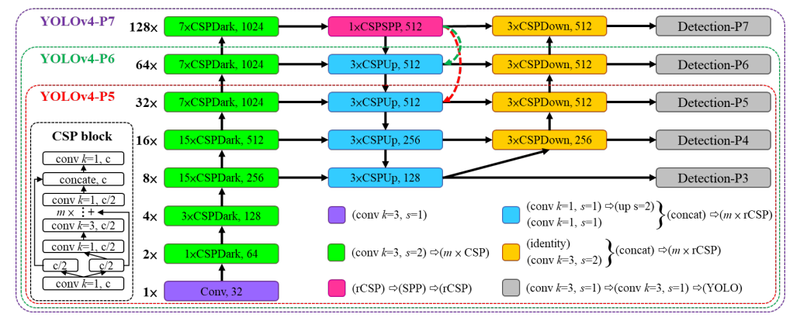  

>Scaled YOLO v4는 발표 당시 기존의 object detection 분야에서 가장 좋은 성능을 가지고 있었다  
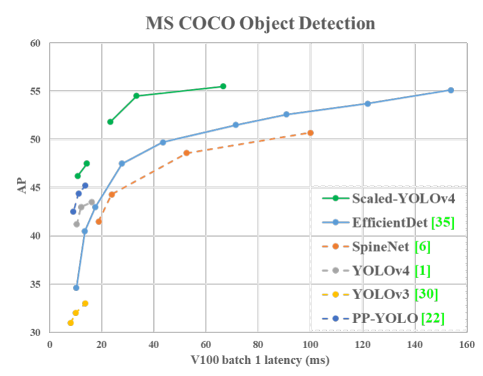  

### PPYOLO v2
2021년 4월 PPYOLO의 업그레이드된 모델인 PPYOLO v2가 공개  
PPYOLO의 성능을 향상시키기 위해 mish 활성화 함수와 Path Aggregating Network 등 다양한 실험 진행  

논문 [PP-YOLOv2: A Practical Object Detector](https://arxiv.org/pdf/2104.10419.pdf)

> PPYOLO v2의 성능과 정확도는 당시의 다른 모델보다 좋았다
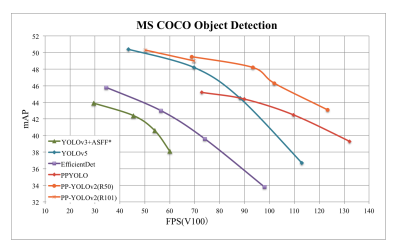  

### YOLOR

2021년 5월에 YOLOR 소개 
YOLOR은 Scaled YOLO v4에서 파생된 모델로 같은 저자에 의해 쓰여졌다  

논문 [You Only Learn One Representation: Unified Network for Multiple Tasks](https://arxiv.org/pdf/2105.04206.pdf)

YOLOR은 사람이 학습할 때 명시적 지식(explicit knowlege)과 암묵적 지식(implicit knowlege)를 사용한다는 것에서 착안  
- **명시적 지식**은 말과 글로 표현할 수 있는 지식  
- **암묵적 지식**은 문자나 언어가 아닌 경험이나 학습에 의해 체득된 지식  

YOLOR은 사람의 일반적인 학습 과정을 딥러닝에 적용하여 general representation을 생성하는 통합된 네트워크를 구성  
이로써 YOLOR은 멀티 태스크를 잘 수행할 수 있었다

YOLOR의 아키텍처는 단순한데,  
YOLO v4 CSP 모델의 feature alignment, prediction refinement, multitask에 암묵적 지식을 아래와 같이 더해주는 것  
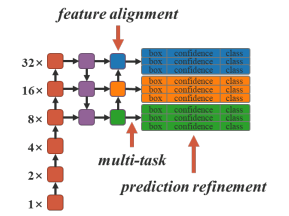  

### YOLOX
2021년 8월에 나온 [YOLOX: Exceeding YOLO Series in 2021](https://arxiv.org/pdf/2107.08430.pdf)  
Anchor-Free Detector, Advanced Label Assignment Strategy, End-to-end Detector 등의 최신 연구를 적용하여 YOLO v3 SPP의 성능을 개선  

YOLOX는 특히 Decoupled Head, Strong Data Augmentation, Anchor-Free, Multi-positives를 통해 성능 향상  
**Decoupled Head**는 prediction하고자 하는 값에 따라 Head를 나누어 학습 속도를 빠르게 했고,  
Detector를 End-to-End 방식으로 만들 수 있었다  

**Anchor-Free**는 ground truth box 와 생성된 bounding box 안의 cell이 겹쳐 있으면 positive, 아니면 negative로 지정하여 detection 수행  
이로 인해 연산량을 낮추고, 일반화를 시킬 수 있으며 class imbalance 문제도 해결하고, 정확도를 높일 수 있다  

그러나 Anchor-Free 방식만으로는 Anchor 메커니즘의 정확도를 따라잡을 수 없었기 때문에 **Multi-positives**를 사용  

**Multi-positives**는 각 객체의 중심과 주변에 해당하는 cell을 positive로 할당하여 예측을 하는 방법  
낮은 loss를 가진 k개의 cell만 학습에 참여시키는 simOTA과 함께 사용하여 정확도를 향상  

베이스라인으로 사용한 YOLO v3과의 차이  
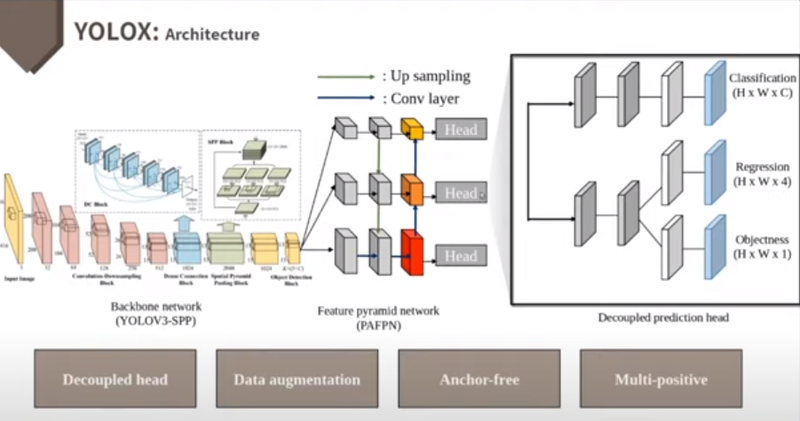  

### YOLOS
NLP 분야에서 큰 영향을 끼치고 있는 Transformer는 CV에서도 점차 영향력을 키우고 있다  
이런 흐름에 맞춰 2021년 10월 YOLOS라는 모델이 소개  

논문 [You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection](https://arxiv.org/pdf/2106.00666.pdf)

YOLOS는 Transformer Encoder와 NLP Heads만을 사용해 2D object detection을 수행한 모델  

YOLOS의 성능은 최근에 나온 다른 YOLO 게열의 모델과 비교했을 때 아주 좋지는 않은데,  
YOLO v3이나 RetinaNet와 비슷한 정도의 성능을 보이고 있다  

하지만 Transformer를 object detection에 적용했다는 점에서 주목해볼만 하다

#### YOLOS의 모델 구조
Transformer와 DETR의 Bipartite Loss를 합친 모델  
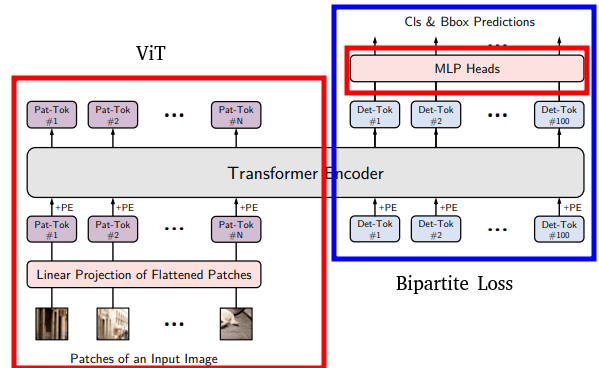  

---
## SSD(Single Shot MultiBox Detector)
YOLO가 1 stage로 object detection을 할 수 있다는 증명을 한 뒤, 1 stage detector는 수많은 발전을 이루었다  
SSD는 YOLO v1에서 grid를 사용해서 생기는 단점을 해결할 수 있는 아래와 같은 몇 가지 테크닉을 제안  
- Pre-defined Anchor Box
- Image Pyramid

논문 [SSD: Single Shot MultiBox Detector](https://arxiv.org/pdf/1512.02325.pdf)

### SSD의 Workflow
YOLO v1의 두번째 단점은 box 정보 (x, y, w, h)를 예측하기 위한 seed 정보가 없기 때문에 넓은 bbox 분포를 모두 학습할 수 없었다는 점  
이로 인한 성능 손실이 존재하여 Faster R-CNN 등 에서 사용하는 anchor를 적용할 필요

만약 개가 등장하는 bounding box가 존재한다면, 그 bounding box만의 x, y, w, h 특성이 존재하기 때문에  
pre-defined된 box의 x, y, w, h를 refinement하는 layer를 추가하는 것이 이득이었다  

이 anchor box를 SSD에서는 **Default box**라고 부른다

### Image Pyramid
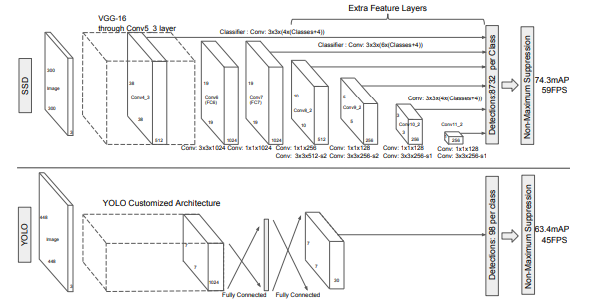  

Image Pyramid는 ImageNet으로 사전학습된 VGG16을 사용  

VGG에서 pooling layer를 거친 block은 하나의 image feature로 사용 가능  

YOLO에서 7x7 크기의 feature map 하나만을 사용했다면,  
SSD는 38 x 38, 19 x 19, 10 x 10, 5 x 5, 3 x 3, 1 x 1인 다양한 크기의 feature map을 사용  
각 feature map은 YOLO의 관점에서 보면 원본 이미지에서 grid 크기를 다르게 하는 효과가 있었다  

따라서 5 x 5 크기의 feature map에서 grid가 너무 커서 작은 물체를 못찾는 문제를 38 x 38 크기의 feature map에서 찾을 수 있는 단서를 마련  

즉 SSD는 서로 다른 크기의 feature map에서 object detection을 해서 작은 물체는 큰 feature map에서, 큰 물체는 작은 feature map에서 찾을 수 있게 한 것  

각 단계에서 추출된 feature map은 detector와 classifier를 통과해 object detection을 한다  

각 feature map에는 bounding box와 클래스 정보가 담겨 있는데, 이 feature map들을 2번 convolution 한다  

위의 그림에서 보면 Classifier: Conv: ...라고 쓰여있는 부분에서 1번 더 convolution  

3 x 3 x (default box의 수 x (class의 수 + 4)의 가중치로 convolution을 하여  
n x n x (default box의 수 x (class의 수 + 4))의 feature map을 얻는다  

여기서 class는 PASCAL VOC의 클래스 20개와 배경 클래스를 합해 21 + 4는 bounding box의 위치 정보 x, y, w, h의 개수

아래의 그림은 위의 그림에서 생략되었던 detector와 classifier를 포함한 아키텍처
각각의 feature map에서 뽑아낸 6개의 classifier의 예측을 NMS를 사용해 confidence가 가장 높은 box 하나만 남겨 최종 detection  
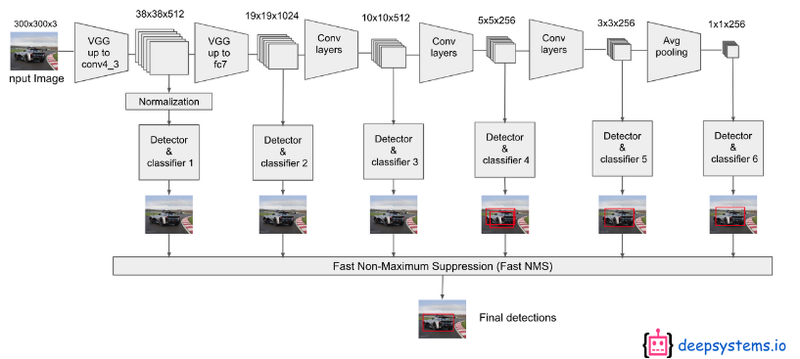  

> YOLO와 비교하였을 때 최소 feature map의 개수만큼 계산량이 많다. 38 x 38 크기의 feature map은 box를 계산하기에는 충분히 깊지 않은 network일 수 있다

### SSD의 framework
SSD는 입력 이미지와 각 객체에 대한 ground truth box만을 필요로 한다  

convolution을 할 때 비율이 다른 default box를 설정  
아래의 그림은 다른 크기의 feature map에서, 각 객체마다 다른 비율의 default box를 4개씩 만들어 놓은 것을 표현한 것  

default box에서 default box와 대응되는 bounding box regression을 적용하여 box의 (x, y, w, h)를 찾고  
confidence, 즉 box 안에 물체가 있는지 없는지를 예측하는 점수를 예측  

학습할 때 이 default box와 ground truth box를 비교해 ground truth box와 비슷한 default box를 선택하여 positive, 나머지는 negative로 설정  
고양이는 개보다 작기 때문에 8 x 8 feature map에서는 고양이를 잡아내고, 4 x 4 feature map에서는 개를 잡아낸 것을 볼 수 있다  

이렇게 각 레이어에서 피쳐 맵들을 가져와 Object Detection을 수행한 결과들을 모두 합하여 localization loss와 confidence loss를 구한 다음,  
전체 네트워크를 학습시키는 방식으로 1 Step end-to-end Object Detection 모델을 구성하였다  
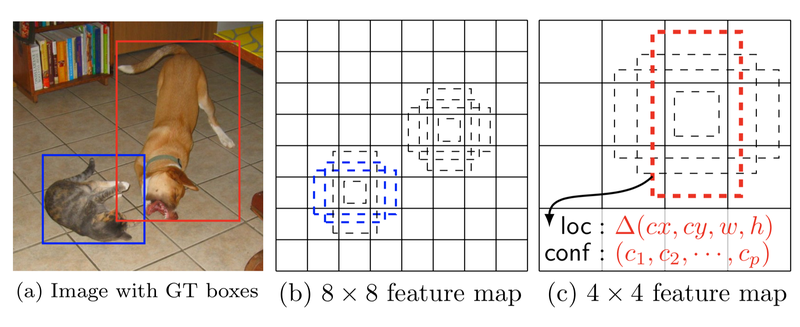  

### Default box를 위한 scale
다양한 크기의 Default box 생성을 위해 SSD는 아래와 같은 식을 사용  
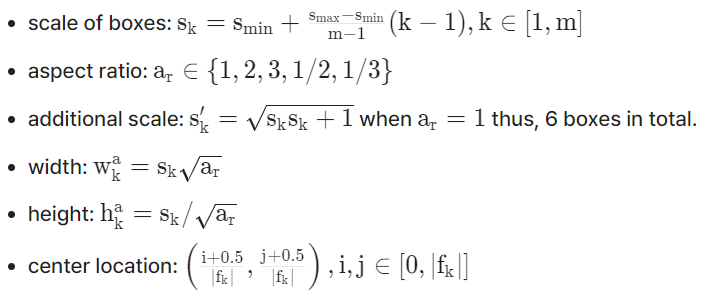  

map의 개수를 m, Smin을 0.2, Smax를 0.9라고 하고, 위의 식에 넣으면  
각 feature map당 서로 다른 6개의 s 값(scale 값) [0.2, 0.34, 0.48, 0.62, 0.76, 0.9]이 나온다  

이 값은 각 feature map에서 default box의 크기가 입력 이미지의 너비와 높이에 비해 얼마나 큰 지를 보여준다  

여기서 aspect ratio를 {1, 2, 3, 1/2, 1/3}로 설정하여 default box의 너비와 높이를 구할 수 있다  
> 예를 들어
 k=3이라면 scale은 0.48
 aspect ration가 2라면 너비는 0.68, 높이는 0.34
논문에서는 1개의 box를 더 추가해 총 6개의 default box의 너비와 높이 값을 구한다.

입력 이미지에서 default box가 위치할 중심점(center location)의 식에서 fk는 k번째 feature map의 크기  

대략 예측되는 상자가 정사각형이나 가로로 조금 길쭉한 상자, 세로로 조금 길쭉한 상자이기 때문에 2:3으로 임의로 정해도 학습이 잘 되지만,  
특이한 경우, 즉 가로 방향으로 걸어가는 지네와 같은 경우에 위의 비율로 정하면 threshold를 0.5로 했을 때 학습이 되지 않는다  

따라서 학습할 이미지에 따라서 aspect ration를 조정해야 한다  
임의로 정하는 것은 비효율적이므로 KNN과 같은 알고리즘을 활용하면 좋은 결과가 나올 수 있다.

이렇게 구해준 중심점 좌표들에 원래의 입력 이미지의 크기를 곱해 중심점을 구하고,  
각 중심점마다 default box를 그릴 수 있습니다.
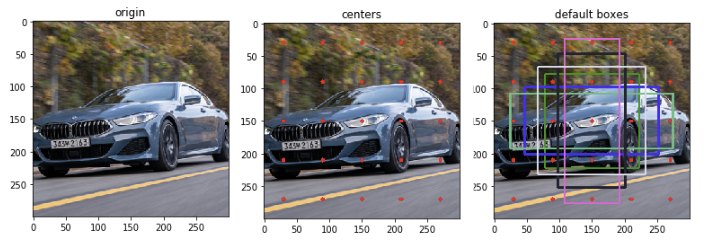  

### SSD의 Loss와 성능

#### Matching strategy
학습 전에 ground truth와 defalt box의 jaccard overlap(IoU)이 0.5 이상인 것을 미리 매칭시켜 positive sample로 설정  
jaccard overlap이 0.5 이상인 default box를 모두 사용하면 학습 문제를 단순화시켜서 더 높은 성능을 가져올 수 있다  

### SSD Loss function
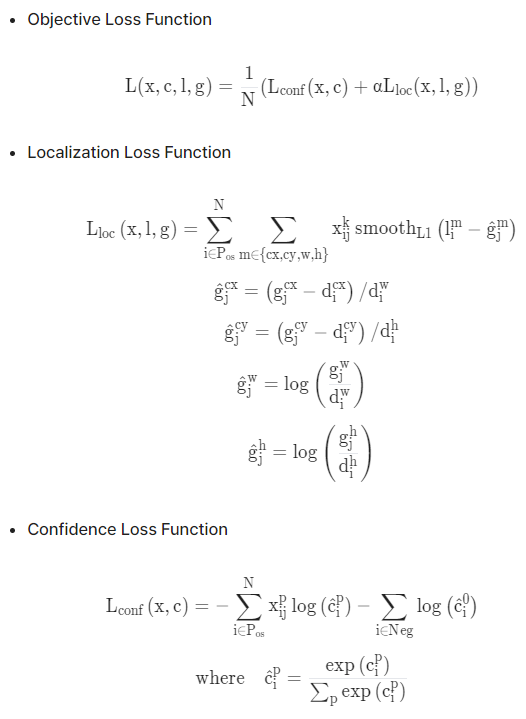  
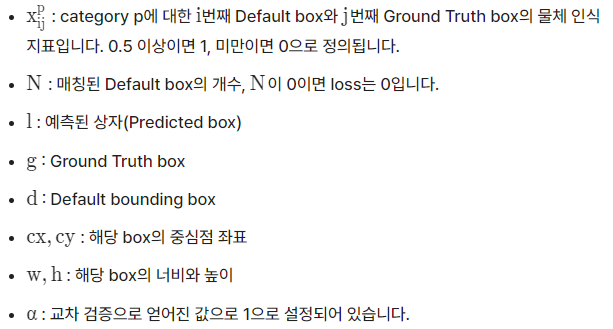  


#### Objective Loss Function
전체 로스 = Lconf(각 클래스 별로 예측한 값과 실제값 사이의 차이) +  Lloc(bounding box regression 예측값과 실제값 사이의 차이)

#### Localization Loss Function
예측된 박스 l과 Ground truth box g 파라미터 사이의 **Smooth L1 loss**(즉 bounding box regression loss)
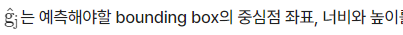  

x, y 좌표 값은 절대값이므로 예측값과 실제 값 사이의 차를 default 박스의 너비 혹은 높이로 나누어 0과 1 사이로 정규화하였고, 너비와 높이의 경우엔 로그를 씌워준다  

#### Confidence Loss Function
여러 클래스의 confidence에 대한 softmax loss (cross entropy loss와 비슷하다)  
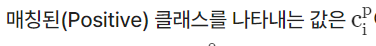  
그 매칭된 클래스에 softmax를 취해준다  
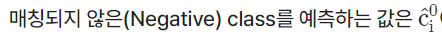  
배경이면 1, 아니면 0의 값을 가진다  
 
즉 최종 예측된 클래스 점수는 예측할 클래스 + 배경 클래스를 나타내는 지표  


### Hard negative mining
대부분의 Default box가 배경이기 때문에 xij^p이 0인 경우가 많다  
따라서 마지막 class의 loss 부분에서는 default box를 high confidence 순으로 정렬해 상위만 가져다 써서   
positive:negative 비율을 1:3으로 정해 출력한다  
> 최적화 속도가 빨라지고 안정적으로 학습

### SSD의 성능
SSD의 성능은 아래와 같이 Faster R-CNN보다는 성능이 조금 낮지만 속도는 빠르고 YOLO보다는 성능이 높고 속도는 느리다  
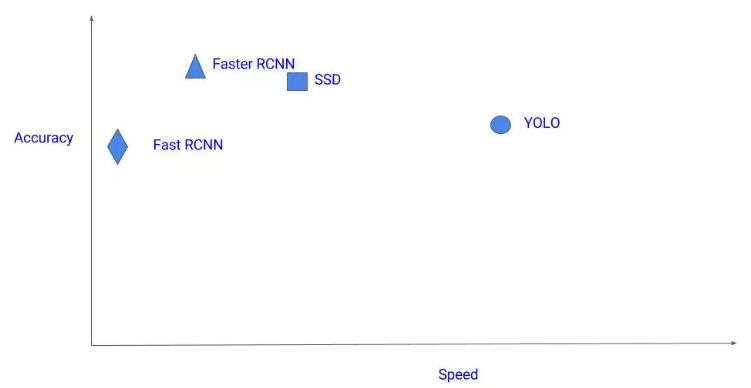  

YOLO가 작은 물체를 잘 찾아내지 못했던 것 역시 SSD에서는 어느 정도 해결한 것 같다  
심지어 YOLO v2보다 성능이 더 좋다는 것을 알 수 있다  
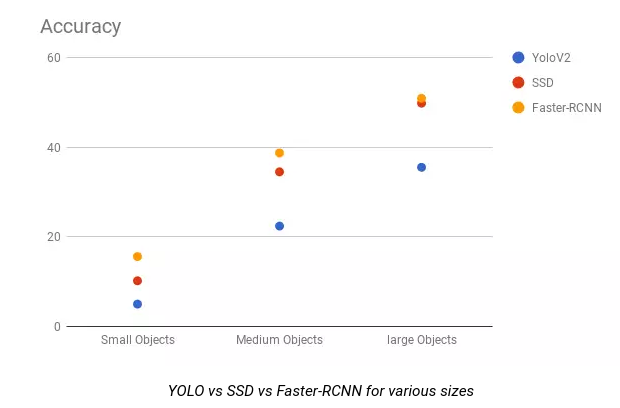  

### FCOS
[FCOS:Fully Convolutional One-Stage Object Detectionan](https://arxiv.org/pdf/1904.01355.pdf)

기존의 anchor box기반에서 벗어나 pixelwise로 예측하는 FCOS를 제안  
Anchor box를 사용하면서 생기는 부작용(예: 학습 계산량, 하이퍼파라미터에 민감한 성능 등)을 해결하면서도 좋은 성능을 보인다

참고 자료 [Brief Review of Anchor-Free Object Detection](https://blog.si-analytics.ai/72)

---
## Face Detection을 위한 모델들

SSD 이후로 특히 Face Detection 모델이 지속적으로 발표되었다  
papers with code에서 검색하면 Face Detection에 대한 다양한 모델을 살펴볼 수 있다  

### SOTA Face Detection 모델

#### TinaFace
Object Detection에서 사용했던 기법을 사용해 단순하지만 좋은 성능을 보이는 모델인 TinaFace를 소개
논문 [TinaFace: Strong but Simple Baseline for Face Detection](https://arxiv.org/pdf/2011.13183v3.pdf)  

Face Detection과 Object Detection이 다르지 않다는 점을 지적  
TinaFace는 백본으로 ResNet50을 사용  
기존에 존재했던 모듈(Feature Pyramid Network, Inception block, FCN 등)을 활용  
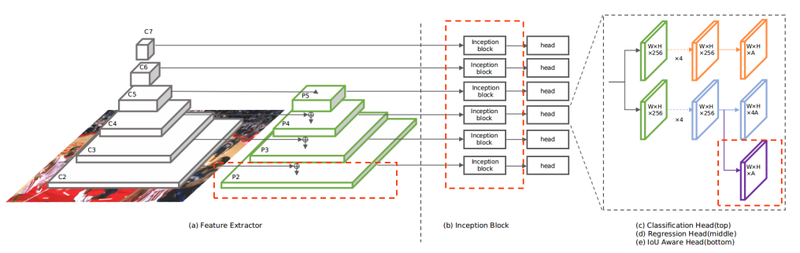  

### RetinaFace
RetinaFace는 1-Stage face detector로서, 다양한 얼굴 크기에 대해 pixel-wise face localization을 수행  

이를 위해 기존의 box classification과 regression 브랜치와 함께 extra-supervised and self-supervised multi-task learning  

그 결과는 아래의 그림에 나와 있듯 face score, face box, 5개의 얼굴 랜드마크, 3D face vertices(정점)  

논문 [RetinaFace: Single-stage Dense Face Localisation in the Wild](https://arxiv.org/pdf/1905.00641.pdf)
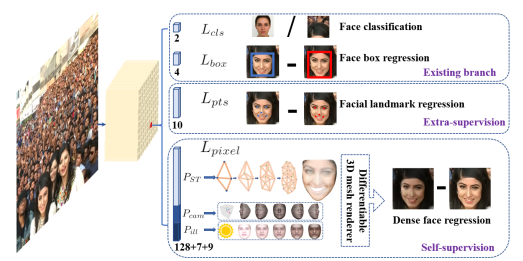  

### DSFD
DSFD는 Feature Enhance Module(FEM), Progressive Anchor Loss(PAL), Improved Anchor Matching (IAM)라는 기법을 사용해 성능을 높인 모델 

언급한 세 기법이 two-stream으로 디자인되어 있어서 Dual Shot Face Detector라는 이름이 붙었다  

논문 [DSFD: Dual Shot Face Detector](https://arxiv.org/pdf/1810.10220.pdf)

### S3FD
S3FD는 하나의 deep neural network를 사용해 다양한 얼굴 크기에 대해 face detection을 수행  
특히 작은 얼굴을 잘 찾는 모델  

다양한 크기의 얼굴을 잘 찾기 위해 layer의 넓은 범위에 anchor를 바둑판 형식으로 배열  
anchor 크기도 새롭게 디자인  

그 외에도 작은 얼굴을 잘 찾기 위해 다양한 기법을 사용

논문 [S3FD: Single Shot Scale-invariant Face Detector](https://arxiv.org/abs/1708.05237)
